In [ ]:
from captum.attr import FeatureAblation
from captum.robust import PGD,FGSM,AttackComparator,MinParamPerturbation
import torch,collections,torchvision,torch.nn as nn,matplotlib.pyplot as plt,torchvision.transforms as transforms
transform_tensor=transforms.ToTensor()
normalize=transforms.Normalize((0.5,0.5,0.5),
                               (0.5,0.5,0.5))
unnormalize=lambda x:0.5*x+0.5
testset=torchvision.datasets.CIFAR10(root='1-attribution/1-interpreting_vision_with_cifar',
                                     train=False,
                                     download=True,
                                     transform=transform_tensor)
testloader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False,num_workers=2)
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool1=nn.MaxPool2d(2,2)
        self.pool2=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        self.relu1=nn.ReLU()
        self.relu2=nn.ReLU()
        self.relu3=nn.ReLU()
        self.relu4=nn.ReLU()
    def forward(self,x):
        x=self.pool1(self.relu1(self.conv1(x)))
        x=self.pool2(self.relu2(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=self.relu3(self.fc1(x))
        x=self.relu4(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()
softmax=nn.Softmax(dim=1)
def image_show(img,pred):
    npimg=img.squeeze().permute(1,2,0).detach().numpy()
    plt.imshow(npimg)
    plt.title(f'Prediction: {pred}')
    plt.show()
def get_prediction(model, input, normalize_im=False):
    if normalize_im:
        input=normalize(input)
    output=model(input)
    _,pred=torch.max(output,dim=1)
    return classes[pred],softmax(output)[:,pred]
net.load_state_dict(torch.load('1-attribution/1-interpreting_vision_with_cifar/cifar_torchvision.pt'))

<All keys matched successfully>

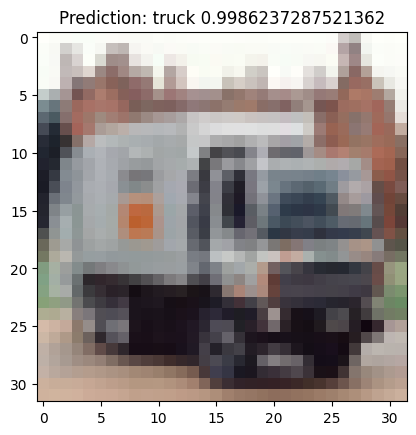

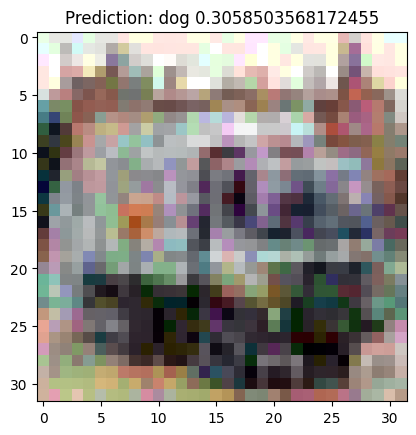

In [2]:
image,label=testset[11]
image=image.unsqueeze(0)
image.requires_grad=True
pred,score=get_prediction(net,image,normalize_im=True)
fgsm=FGSM(net,lower_bound=-1,upper_bound=1)
perturbed_image_fgsm=fgsm.perturb(normalize(image),epsilon=0.16,target=label) 
new_pred_fgsm,score_fgsm=get_prediction(net,perturbed_image_fgsm)
image_show(image,pred+' '+str(score.item()))
image_show(unnormalize(perturbed_image_fgsm),new_pred_fgsm+' '+str(score_fgsm.item()))

/Users/I568200/.pyenv/versions/Environment/lib/python3.14/site-packages/captum/robust/_core/fgsm.py:171: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs)


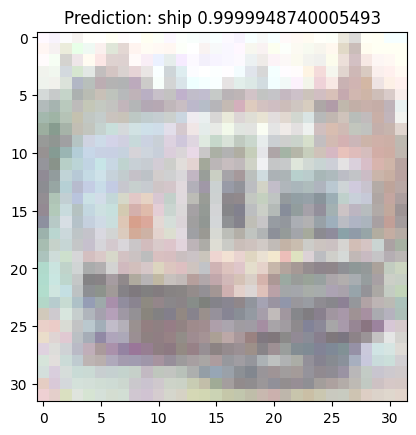

In [3]:
pgd=PGD(net,torch.nn.CrossEntropyLoss(reduction='none'),lower_bound=-1,upper_bound=1)
perturbed_image_pgd=pgd.perturb(inputs=image,
                                radius=0.13,
                                step_size=0.02, 
                                step_num=7,
                                target=torch.tensor([8]),
                                targeted=True) 
new_pred_pgd,score_pgd=get_prediction(net,perturbed_image_pgd)
image_show(unnormalize(perturbed_image_pgd.detach()),new_pred_pgd+' '+str(score_pgd.item()))

# Robustness Metrics
## Attack Comparisons

In [4]:
ModelResult=collections.namedtuple('ModelResults','accuracy logit softmax')
def metric(model_out,target):
    if isinstance(target,int):
        target=torch.tensor([target])
    reshaped_target=target.reshape(len(target),1)
    logit=torch.gather(model_out,1,reshaped_target).detach()
    _,pred=torch.max(model_out,dim=1)
    acc=(pred==target).float()
    softmax_score=torch.gather(softmax(model_out),1,reshaped_target).detach()
    return ModelResult(accuracy=acc,
                       logit=logit,
                       softmax=softmax_score)
comparator=AttackComparator(forward_func=net,
                            metric=metric,
                            preproc_fn=normalize)
comparator.add_attack(transforms.RandomRotation(degrees=30),'Random rotation',num_attempts=100)
comparator.add_attack(transforms.GaussianBlur(kernel_size=3),'Gaussian blur',num_attempts=1)
comparator.add_attack(fgsm,'FGSM',attack_kwargs={'epsilon':0.15},apply_before_preproc=False,additional_attack_arg_names=['target'],num_attempts=1)
comparator.evaluate(image,target=label)

{'Original': ModelResults(accuracy=tensor([1.]), logit=tensor([[13.8934]]), softmax=tensor([[0.9986]])),
 'Random rotation': {'mean': ModelResults(accuracy=tensor([0.9100]), logit=tensor([[6.4991]]), softmax=tensor([[0.7747]])),
  'max': ModelResults(accuracy=tensor([1.]), logit=tensor([[13.8934]]), softmax=tensor([[0.9986]])),
  'min': ModelResults(accuracy=tensor([0.]), logit=tensor([[0.7895]]), softmax=tensor([[0.0718]]))},
 'Gaussian blur': {'mean': ModelResults(accuracy=tensor([1.]), logit=tensor([[6.3445]]), softmax=tensor([[0.9334]]))},
 'FGSM': {'mean': ModelResults(accuracy=tensor([0.]), logit=tensor([[1.3329]]), softmax=tensor([[0.2325]]))}}

In [5]:
comparator.reset()
n_batches=100
for i,(batch,batch_label) in enumerate(testloader):
    if i>n_batches:
        break
    comparator.evaluate(batch,target=batch_label,perturbations_per_eval=50)
comparator.summary()

{'Original': {'mean': ModelResults(accuracy=tensor(0.5901), logit=tensor([4.2675]), softmax=tensor([0.4938]))},
 'Random rotation Mean Attempt': {'mean': ModelResults(accuracy=tensor(0.4727), logit=tensor([3.1763]), softmax=tensor([0.3925]))},
 'Random rotation Max Attempt': {'mean': ModelResults(accuracy=tensor(0.8376), logit=tensor([5.5232]), softmax=tensor([0.6692]))},
 'Random rotation Min Attempt': {'mean': ModelResults(accuracy=tensor(0.1010), logit=tensor([0.8323]), softmax=tensor([0.1280]))},
 'Gaussian blur': {'mean': ModelResults(accuracy=tensor(0.4812), logit=tensor([3.1494]), softmax=tensor([0.4020]))},
 'FGSM': {'mean': ModelResults(accuracy=tensor(0.0495), logit=tensor([-0.8352]), softmax=tensor([0.0565]))}}

## Minimal Perturbation

In [6]:
def gaussian_blur(image,kernel_size):
    blur=transforms.GaussianBlur(kernel_size)
    return blur(image)
min_pert=MinParamPerturbation(forward_func=net,
                              attack=gaussian_blur,
                              arg_name='kernel_size',
                              mode='linear',
                              arg_min=1,
                              arg_max=31,
                              arg_step=2,
                              preproc_fn=normalize,
                              apply_before_preproc=True,
                              num_attempts=5)
alt_im,kernel_size=min_pert.evaluate(image,target=label)
print(f'Minimum kernel size for misclassification: {kernel_size}')

Minimum kernel size for misclassification: 5


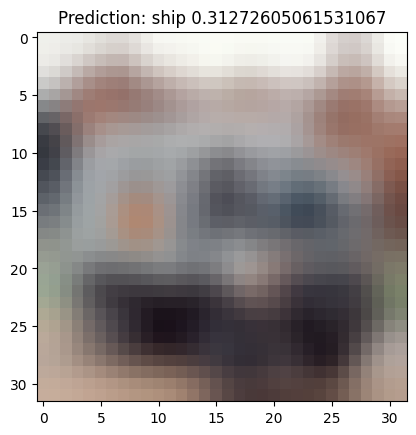

In [7]:
new_pred_blur,score_blur=get_prediction(net,alt_im,normalize_im=True)
image_show(alt_im,new_pred_blur+' '+str(score_blur.item()))

In [8]:
feature_mask=torch.arange(64).reshape(8,8).repeat_interleave(repeats=4,
                                                             dim=1).repeat_interleave(repeats=4,
                                                                                      dim=0).reshape(1,1,32,32)
feature_mask

tensor([[[[ 0,  0,  0,  ...,  7,  7,  7],
          [ 0,  0,  0,  ...,  7,  7,  7],
          [ 0,  0,  0,  ...,  7,  7,  7],
          ...,
          [56, 56, 56,  ..., 63, 63, 63],
          [56, 56, 56,  ..., 63, 63, 63],
          [56, 56, 56,  ..., 63, 63, 63]]]])

In [9]:
ablator=FeatureAblation(net)
attr=ablator.attribute(normalize(image),target=label,feature_mask=feature_mask)
pixel_attr=attr[:,0:1]
def pixel_dropout(image,dropout_pixels):
    keep_pixels=image[0][0].numel()-int(dropout_pixels)
    vals,_=torch.kthvalue(pixel_attr.flatten(),keep_pixels)
    return (pixel_attr<vals.item())*image
min_pert_attr=MinParamPerturbation(forward_func=net,
                                   attack=pixel_dropout,
                                   arg_name='dropout_pixels',
                                   mode='linear',
                                   arg_min=0,
                                   arg_max=1024,
                                   arg_step=16,
                                   preproc_fn=normalize,
                                   apply_before_preproc=True)
pixel_dropout_im,pixels_dropped=min_pert_attr.evaluate(image,target=label,perturbations_per_eval=10)
print(f'Minimum pixels dropped: {pixels_dropped}')

Minimum pixels dropped: 864


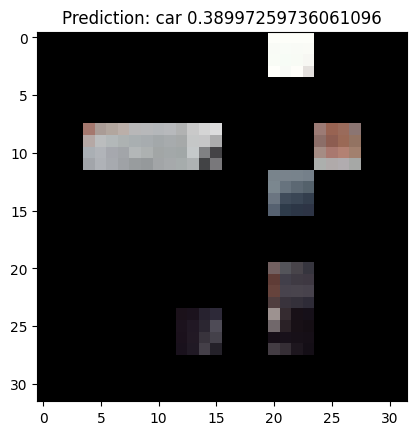

In [10]:
new_pred_dropout,score_dropout=get_prediction(net,pixel_dropout_im,normalize_im=True)
image_show(pixel_dropout_im,new_pred_dropout+' '+str(score_dropout.item()))